In [1]:
# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt

# To supress the deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
#%run utility_functions.ipynb

In [2]:
def Theta2(theta1):
    if theta1 <= np.pi/4:
        theta2 = 0.5 * np.arccos(np.cos(2*theta1)/np.sin(2*theta1))
    if theta1 > np.pi/4:
        theta2 = 0.5 * np.arccos(-np.cos(2*theta1)/np.sin(2*theta1))
    
    return theta2

In [3]:
def theta_maker(theta1):
    if (theta1 == np.pi/8) or (theta1 == 3*np.pi/8):
        theta2 = 0
        theta3 = 0
        return np.array([theta1, theta2, theta3])
    
    
    etaA = np.sin(2 * theta1)
    theta2 = Theta2(theta1)
    theta3 = np.arctan(np.tan(theta1) * np.tan(theta2))
    theta = np.array([theta1, theta2, theta3])
    return theta

In [4]:
# this is a function that implements the cloning that Eve uses
def EveClones(qc, theta1):
    # determine optimizing angles
    theta = theta_maker(theta1)
    
    # prepare to clone 
    qc.u(2*theta[0], 0, 0, 1)
    qc.cx(1,2)
    qc.u(2*theta[1], 0, 0, 2)
    qc.cx(2,1)
    qc.u(2*theta[2], 0, 0, 1)
    
    # execute the cloning component with the input qubit (the 0 qubit here)
    qc.cx(0,1)
    qc.cx(0,2)
    qc.cx(1,0)
    qc.cx(2,0)
    
    qc.barrier()
    
    return qc

In [6]:
def Phase_Measurements(theta, lam, theta1):
    qc = QuantumCircuit(3,2)
    
    # prepare the 0-qubit
    qc.u(theta, 0, lam, 0)
    #qc.h(0)
    
    qc.barrier()

    # Eve prepares her clones
    EveClones(qc,theta1)

    
    qc.u(-theta, -lam, 0, 0)
    qc.measure(0,0)
    qc.barrier()

    qc.u(-theta, -lam, 0, 1)
    qc.measure(1,1)

    shots = 10000 # number of samples used for statistics
    sim = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend = sim, shots = shots)
    
    out00 = job.result().get_counts().get("00")
    out01 = job.result().get_counts().get("01")
    out10 = job.result().get_counts().get("10")
    out11 = job.result().get_counts().get("11")
    
    if out00 == None:
        out00 = 0
    if out01 == None:
        out01 = 0
    if out10 == None:
        out10 = 0
    if out11 == None:
        out11 = 0
        
    Fid_Bob = (out00 + out10)/shots
    Fid_Eve = (out00 + out01)/shots
    
    return Fid_Bob, Fid_Eve

In [7]:
B,E = Phase_Measurements(np.pi/2, 0, np.pi/4 - 0.1)
print(B,E)

0.9885 0.5958


In [15]:
Theta = np.linspace(0,np.pi, 100)
Bs = np.zeros(len(Theta))
Es = np.zeros(len(Theta))

for j in range(len(Theta)):
    Bs[j], Es[j] = Phase_Measurements(Theta[j], 0, np.pi/8 +0.01)

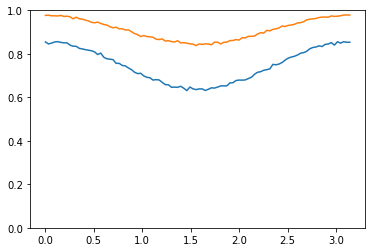

In [20]:
plt.figure()
plt.plot(Theta, Bs)
plt.plot(Theta, Es)
plt.ylim([0,1])
plt.show()

**Summary.** The purpose of this notebook was to see what happens to the cloning fidelity at various levels on the Bloch sphere. When we test for high

In [17]:
Lambda = np.linspace(0, 2*np.pi, 100)
BLs = np.zeros(len(Lambda))
ELs = np.zeros(len(Lambda))

for j in range(len(Lambda)):
    BLs[j], ELs[j] = Phase_Measurements(np.pi/2, Lambda[j], np.pi/8 + 0.01)

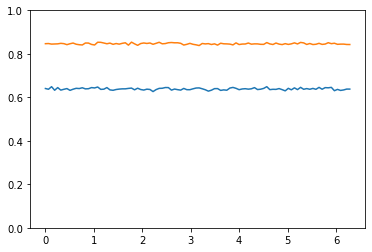

In [19]:
plt.figure()
plt.plot(Lambda, BLs)
plt.plot(Lambda, ELs)
plt.ylim([0,1])
plt.show()